In [1]:
import cv2 as cv
import numpy as np
import random
import matplotlib.pyplot as plt
import skimage
from skimage import io, img_as_float64
from skimage import exposure 
from skimage.restoration import denoise_nl_means, estimate_sigma
%config InlineBackend.figure_format = 'retina' 
import glob
import operator
import math


In [2]:
def display_images(input_path):
    image = io.imread(input_path)
    if image.shape[2] == 3:
        image = skimage.color.rgb2gray(image)
    plt.axis('off') # turn off axis labels 
    plt.imshow(image, cmap = 'gray')
    plt.show()
    image = img_as_float64(image)
    plt.hist(image.flatten(), bins=100, range=(0, 1)) 
    plt.show()
    return image

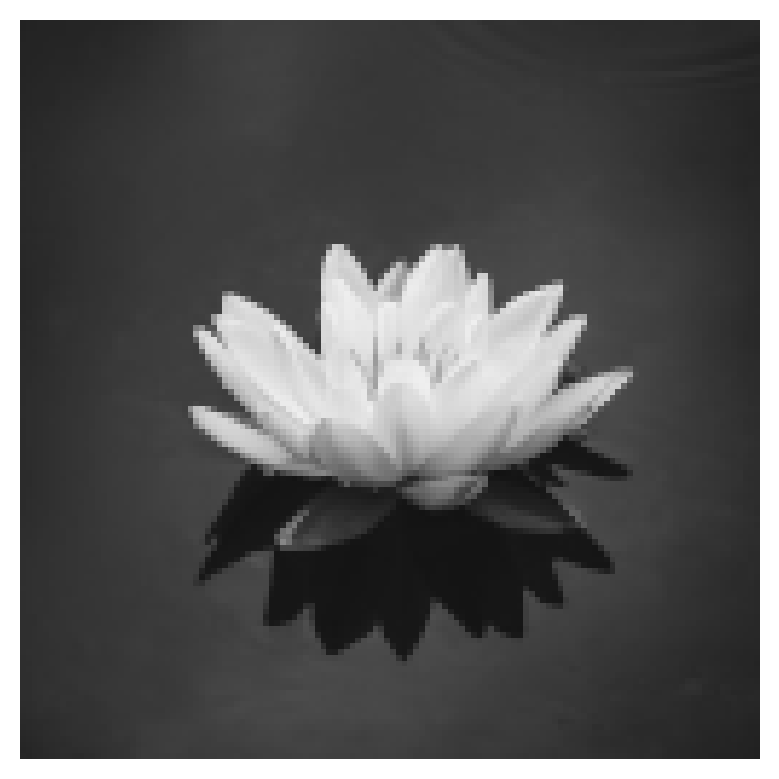

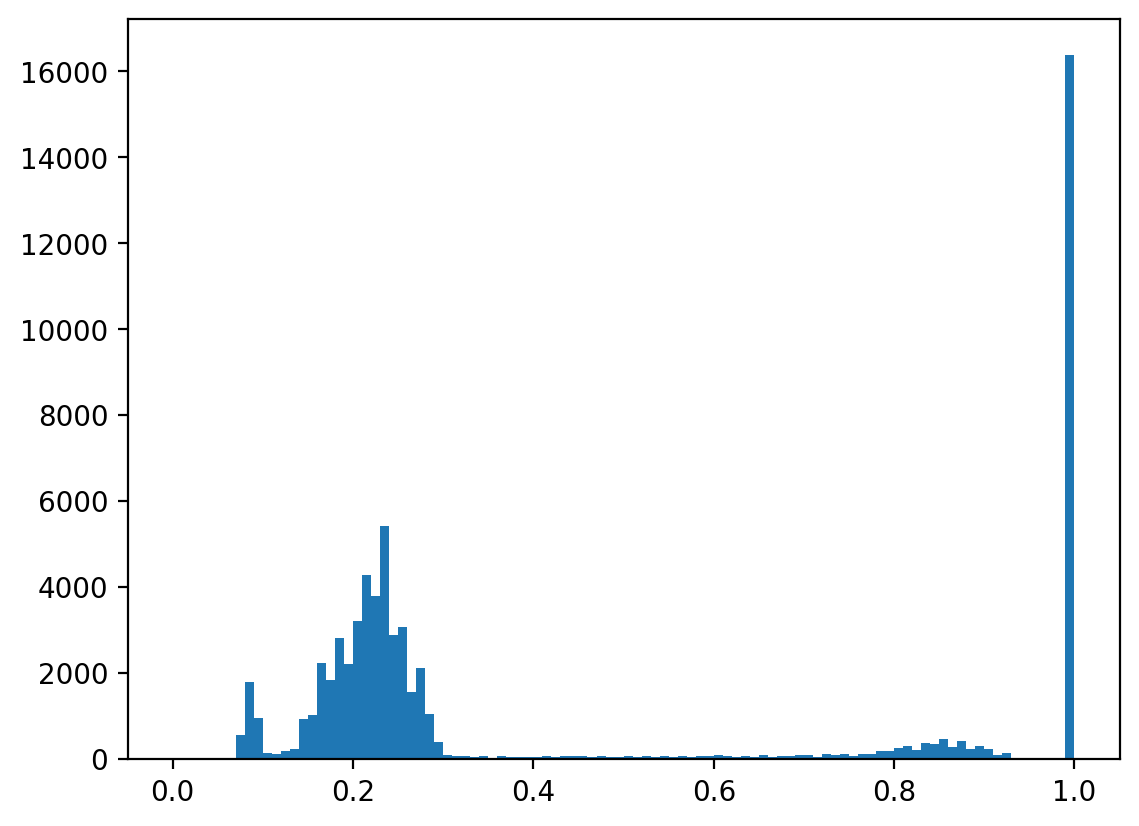

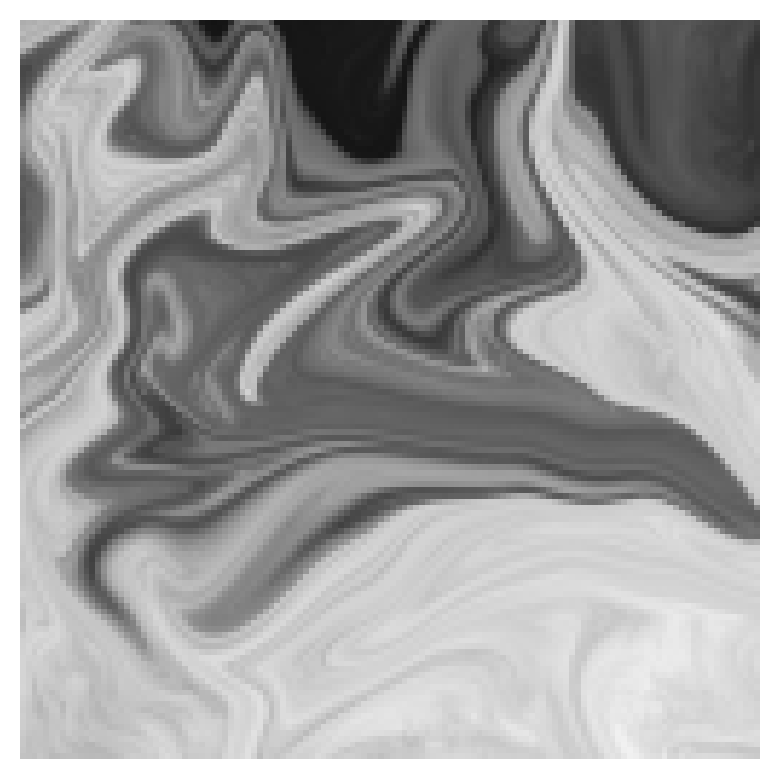

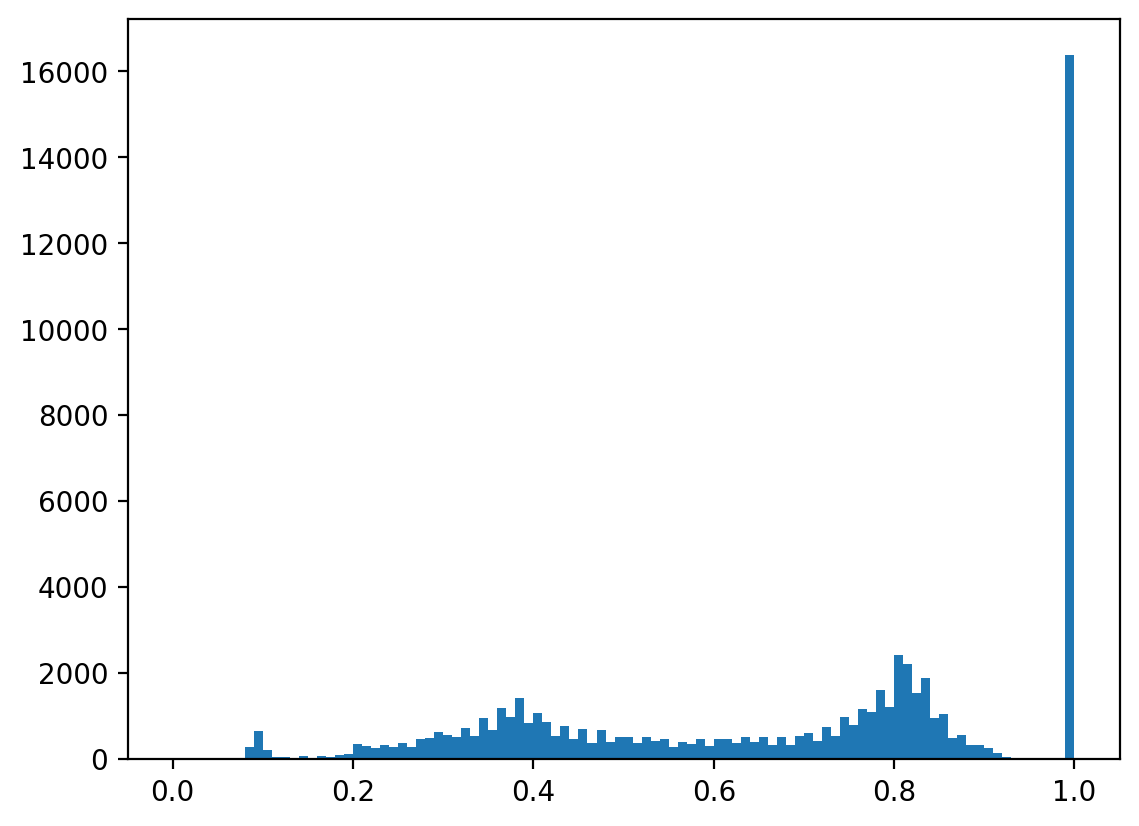

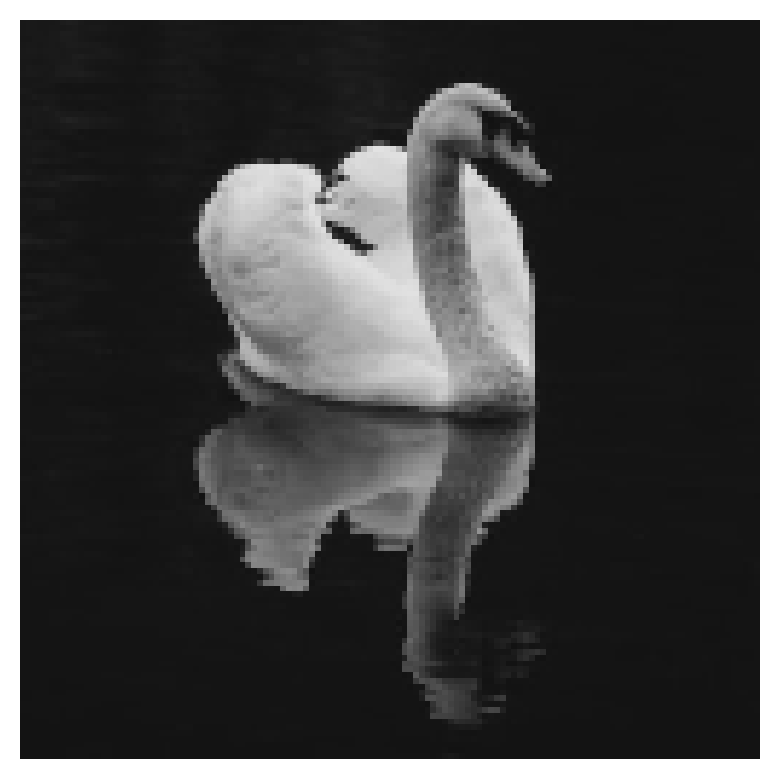

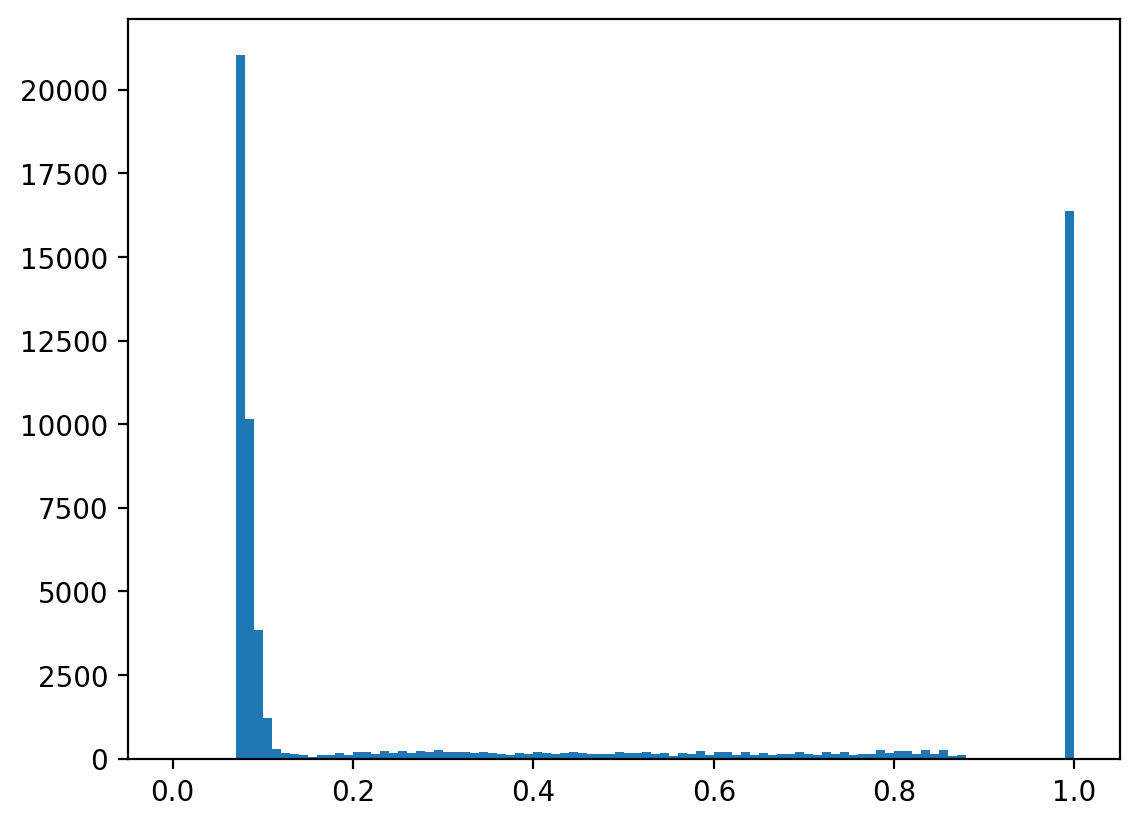

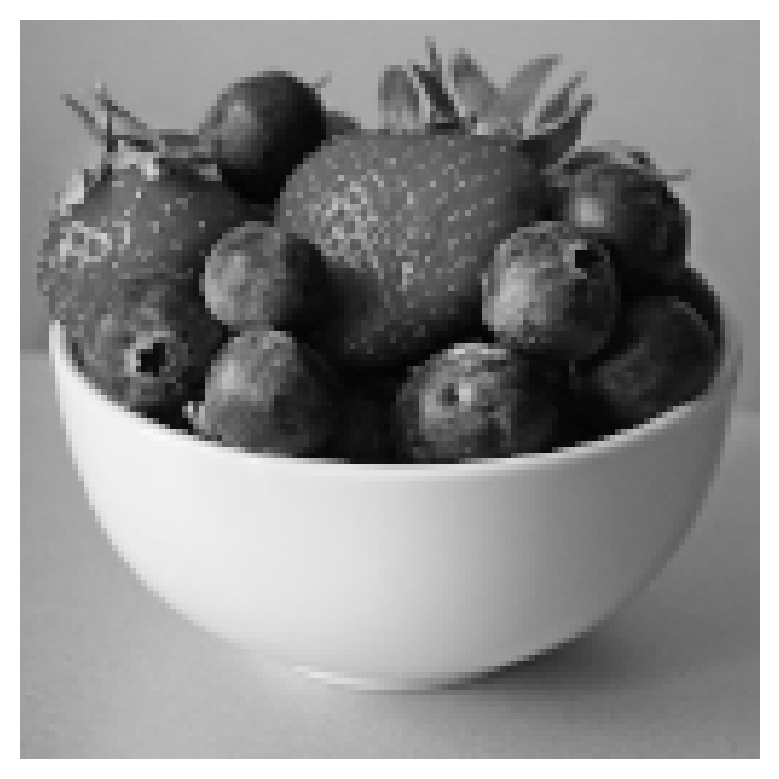

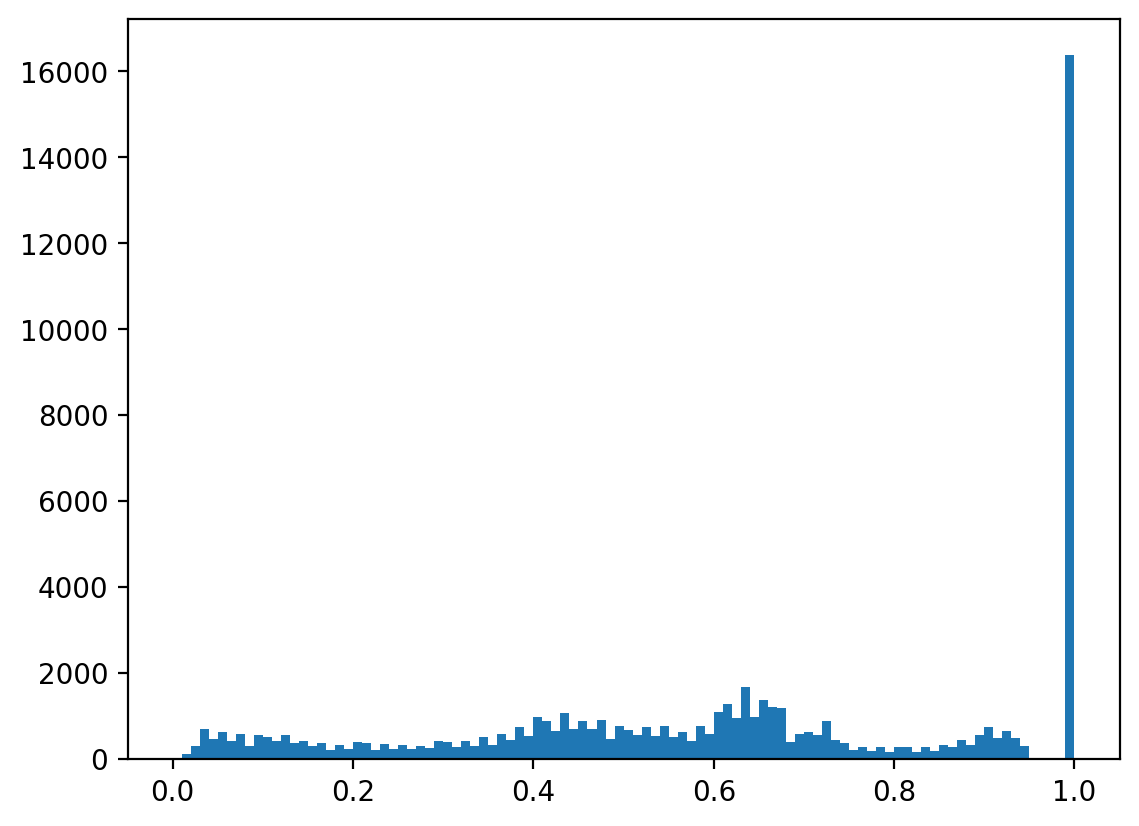

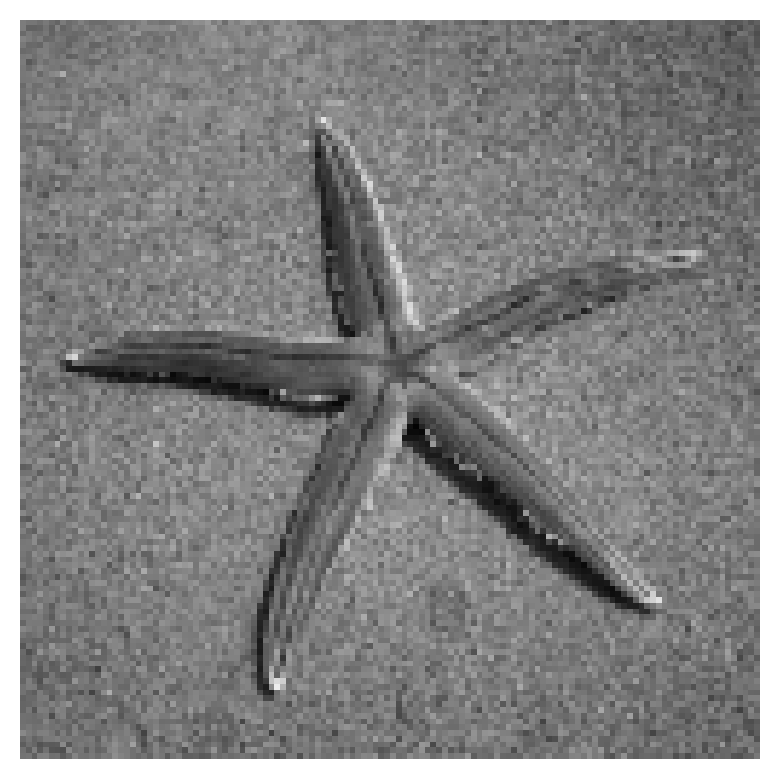

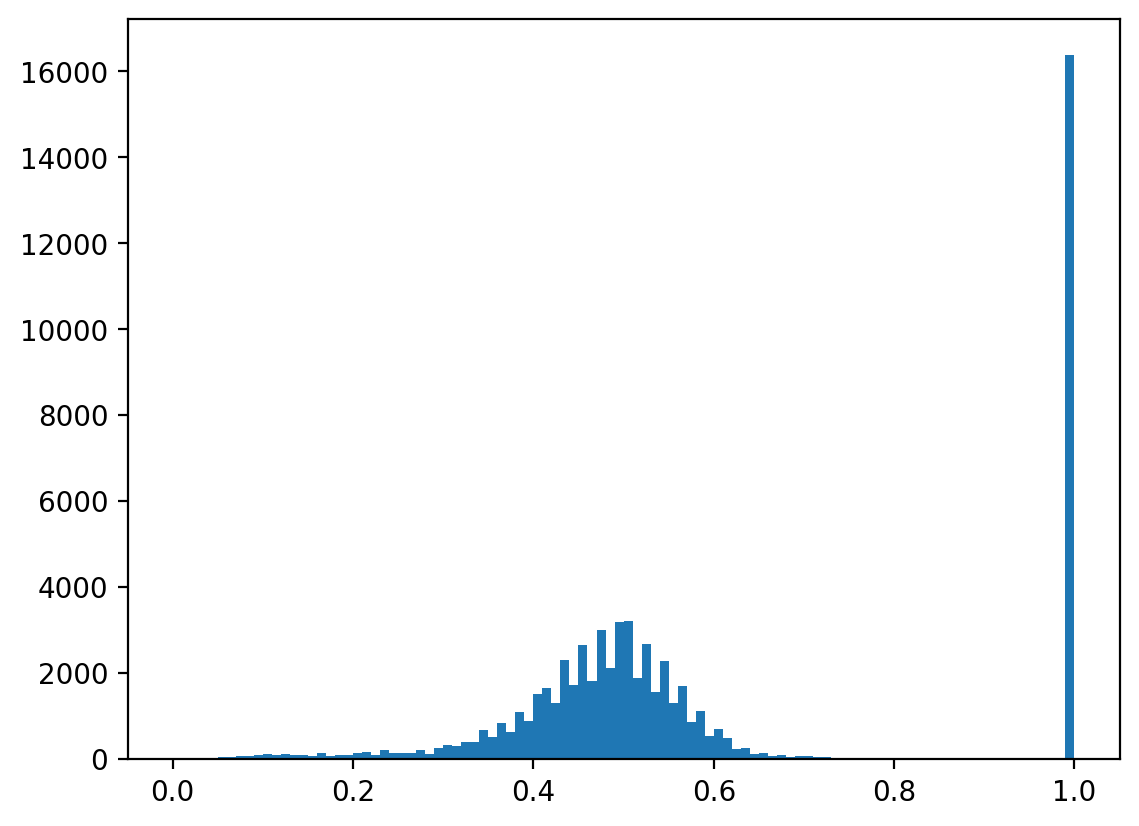

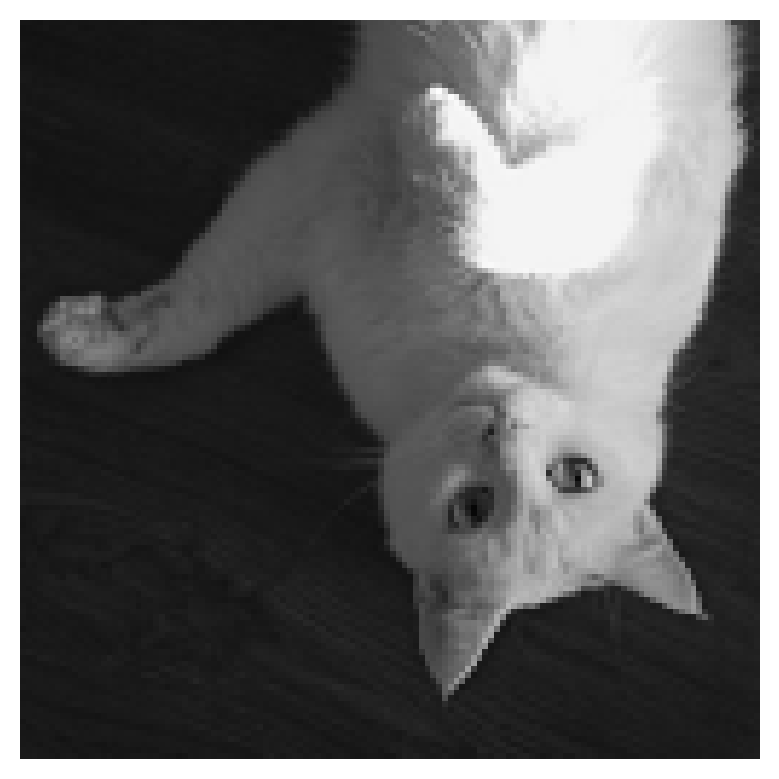

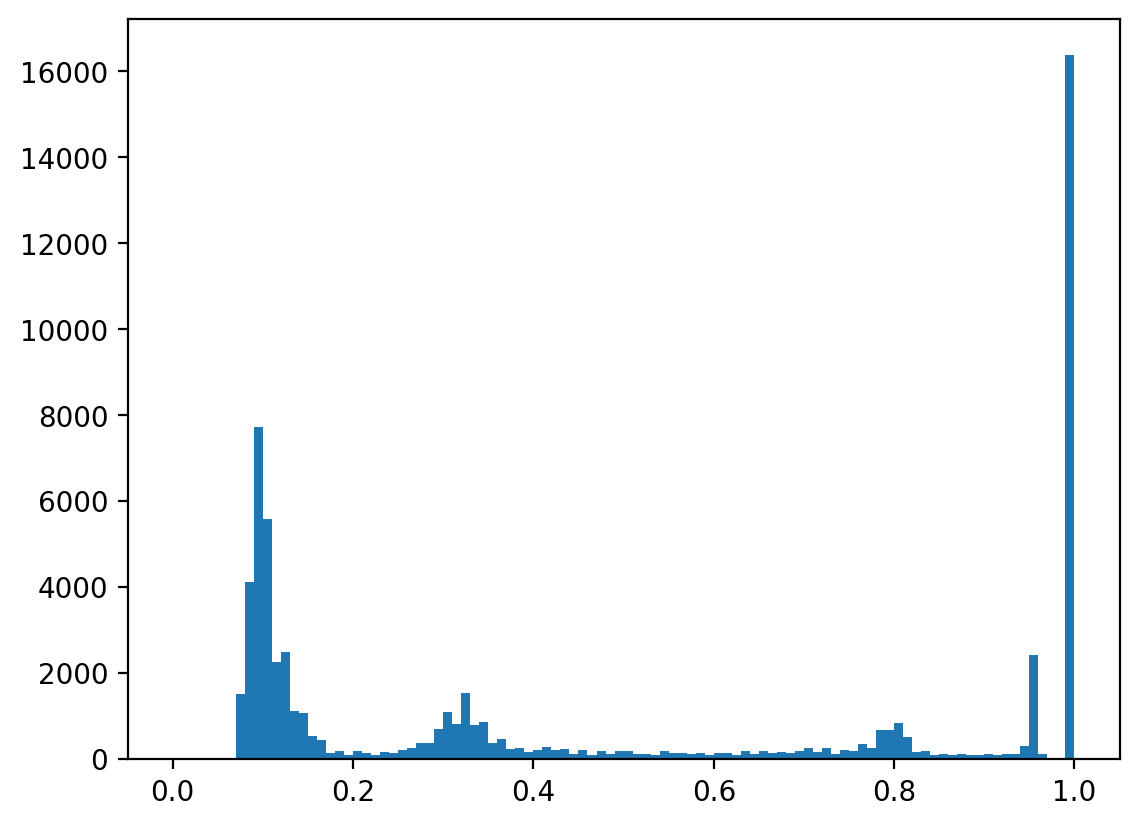

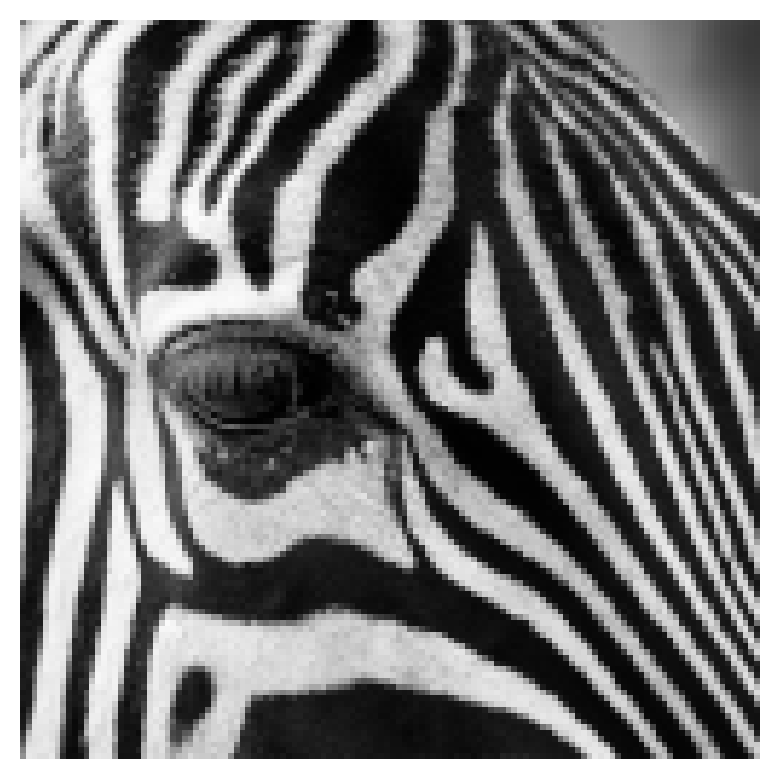

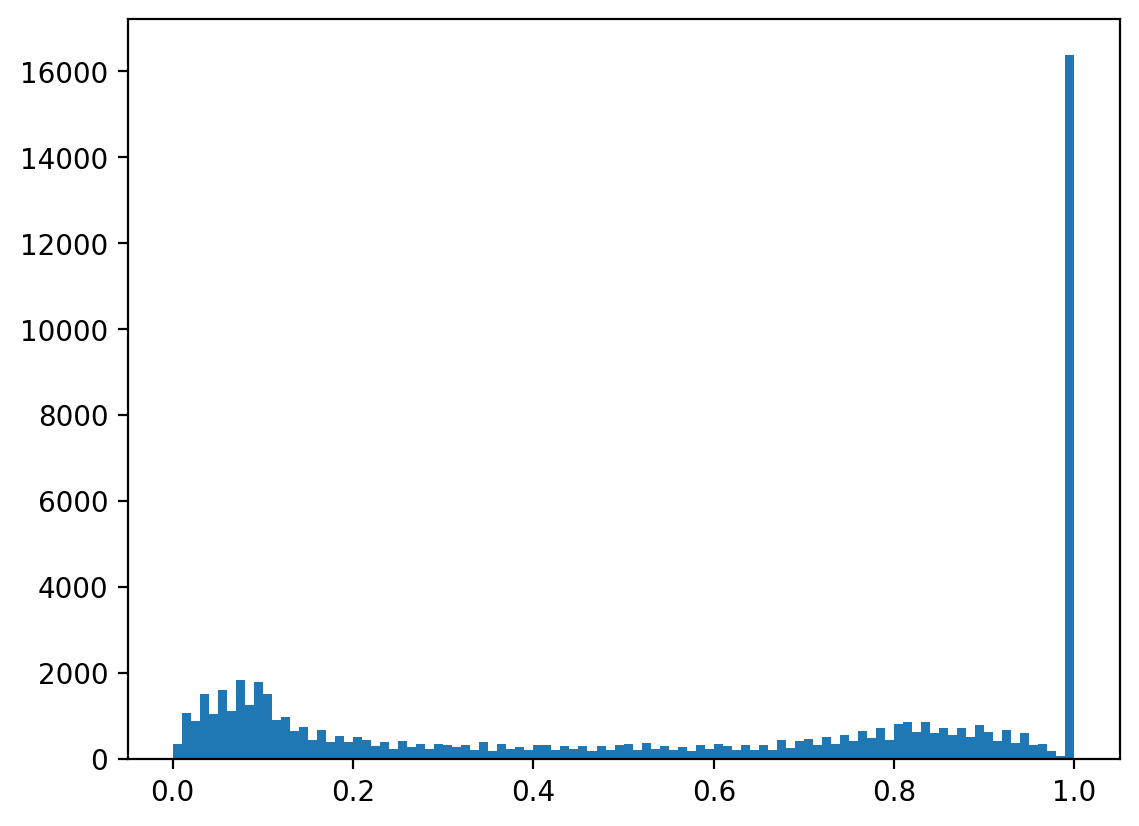

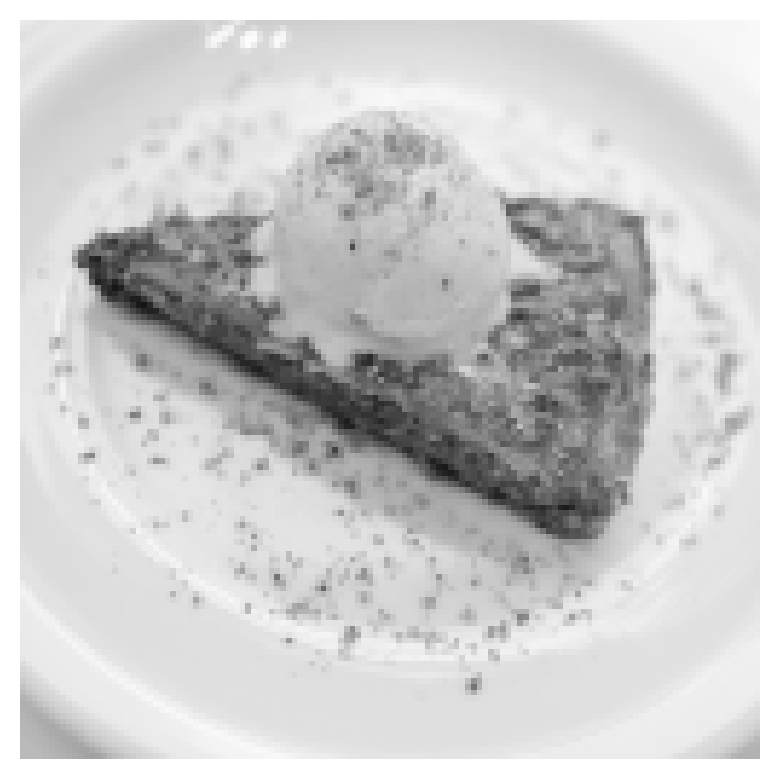

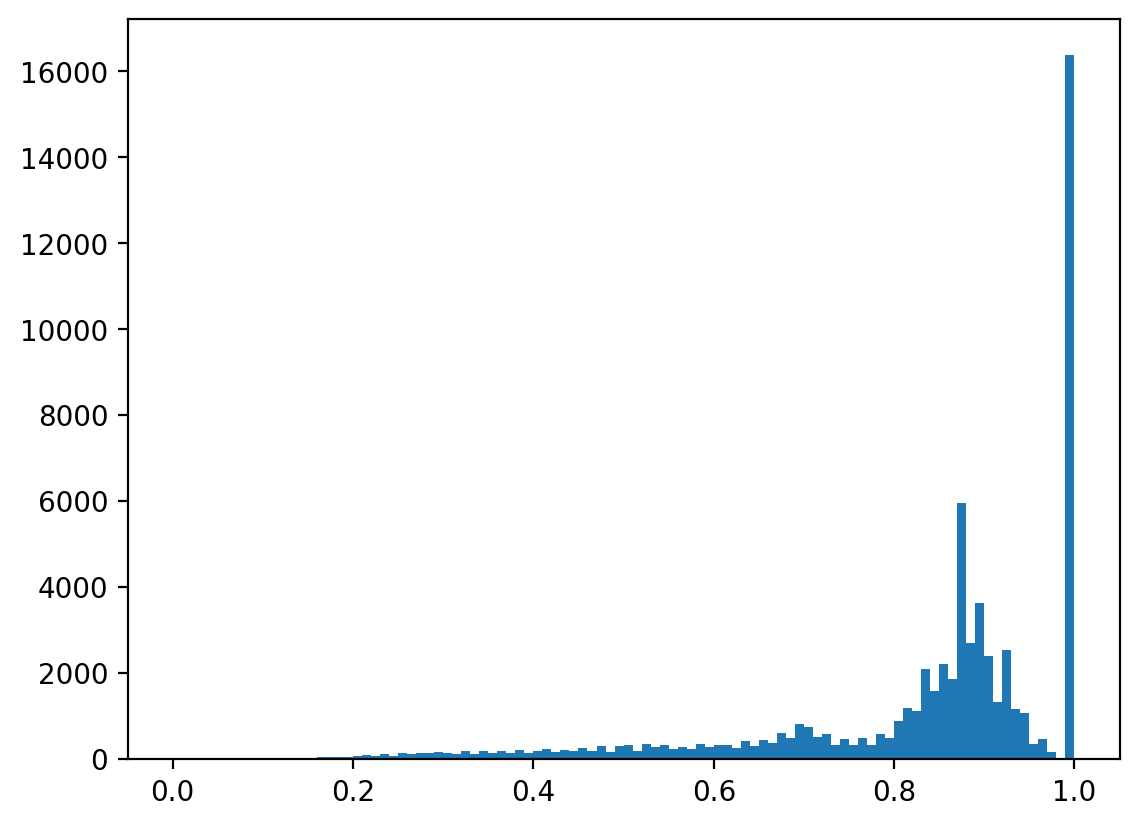

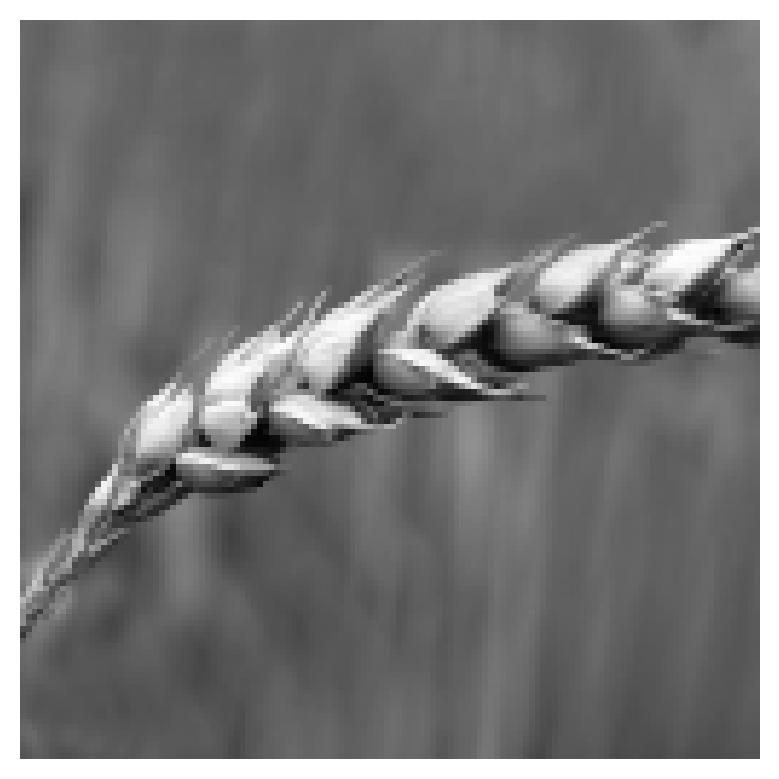

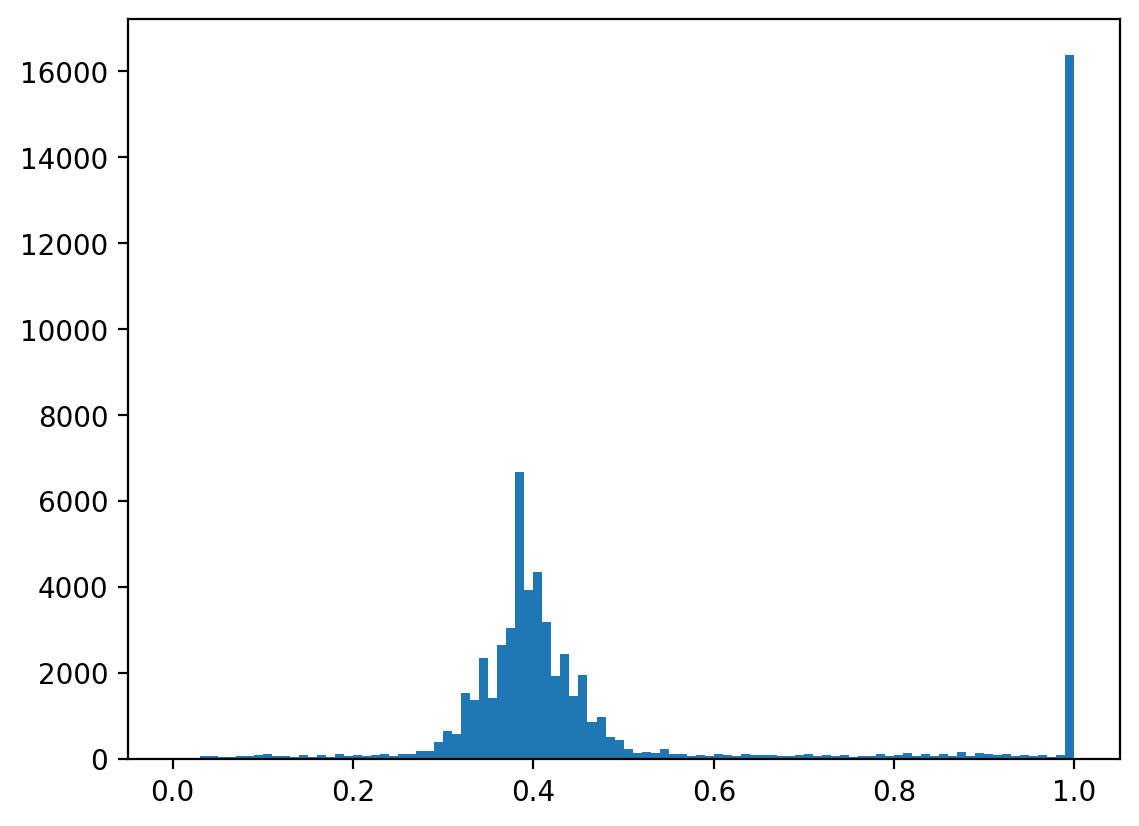

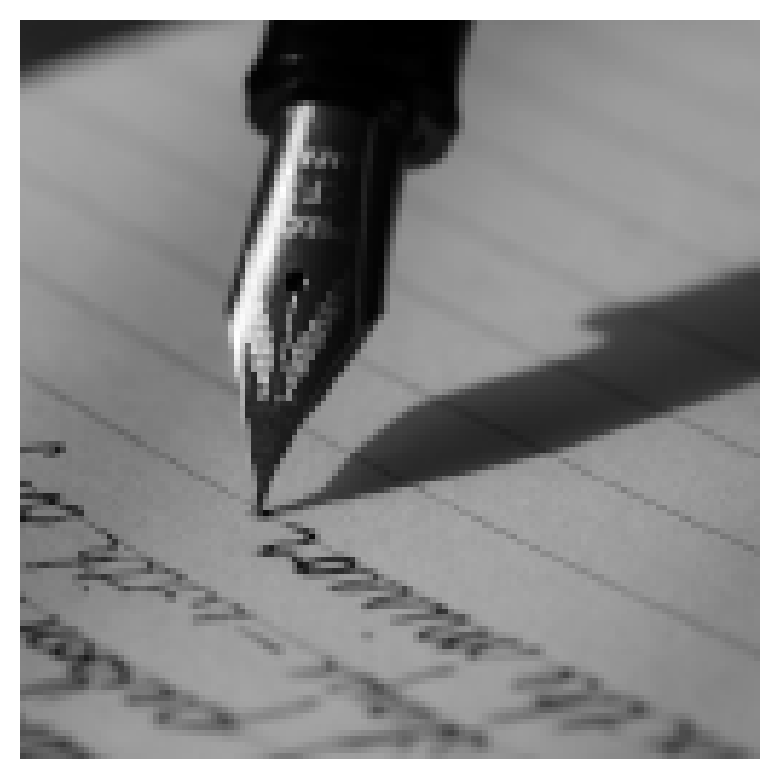

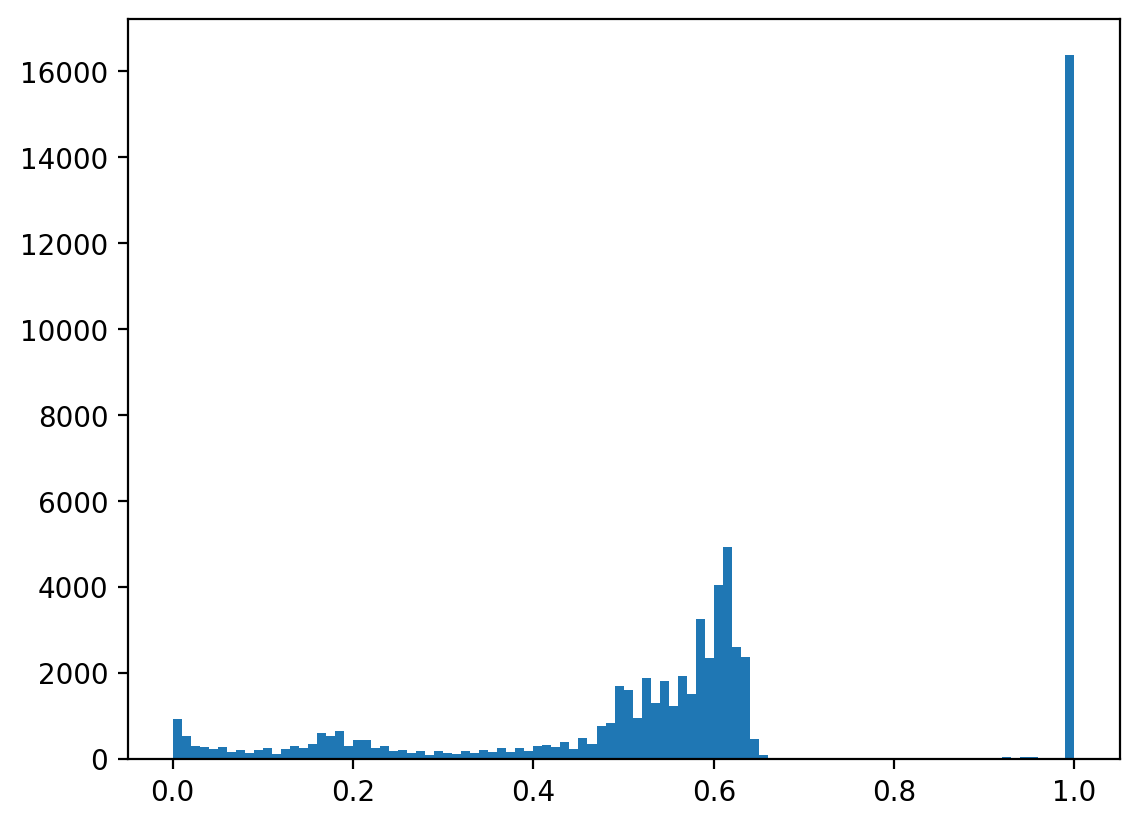

In [3]:
images_paths = glob.glob('Dataset/*')
images = []
for image_path in images_paths: 
    images.append(display_images(image_path))

In [4]:
def denoise_images(image):
    sigma_est = np.mean(estimate_sigma(image, multichannel=True))
    denoise_img = denoise_nl_means(image, h=1.15 * sigma_est, fast_mode=False, 
                                   patch_size=5, patch_distance=3) 
    eq_img = exposure.equalize_adapthist(denoise_img)
#     plt.imshow(eq_img, cmap='gray')
#     plt.show()
#     plt.hist(denoise_img.flat, bins=100)
    return eq_img


In [5]:
denoised = []
for image in images: 
    denoised.append(denoise_images(image))
print(denoised)

/var/folders/t0/jvzj896x3nz8lv9t8_r4mz9m0000gn/T/ipykernel_43992/2596668960.py:2: FutureWarning: `multichannel` is a deprecated argument name for `estimate_sigma`. It will be removed in version 1.0. Please use `channel_axis` instead.
  sigma_est = np.mean(estimate_sigma(image, multichannel=True))
/Users/tushargoyal/opt/anaconda3/lib/python3.9/site-packages/skimage/color/colorconv.py:365: RuntimeWarning: invalid value encountered in multiply
  q = arr[..., 2] * (1 - f * arr[..., 1])


[array([[[0.06937056, 0.0693809 , 0.06944785],
        [0.07729076, 0.07729107, 0.07730061],
        [0.07706966, 0.07710255, 0.07730061],
        ...,
        [0.12834356, 0.12833566, 0.12829336],
        [0.12834356, 0.12834069, 0.12832633],
        [0.12834356, 0.12834072, 0.12831854]],

       [[0.0692652 , 0.06930592, 0.06944785],
        [0.07718251, 0.07720682, 0.07730061],
        [0.07701916, 0.07708179, 0.07730061],
        ...,
        [0.12834356, 0.12832377, 0.12825222],
        [0.12834356, 0.12831743, 0.12821402],
        [0.12018298, 0.12023591, 0.1204908 ]],

       [[0.07718048, 0.07718567, 0.07730061],
        [0.08515337, 0.08512562, 0.08503445],
        [0.08515337, 0.08514169, 0.08511471],
        ...,
        [0.12834356, 0.12833258, 0.12826556],
        [0.12039319, 0.12040877, 0.1204908 ],
        [0.1204908 , 0.1204908 , 0.1204908 ]],

       ...,

       [[0.08907975, 0.08907975, 0.08907853],
        [0.09689279, 0.0969002 , 0.09693252],
        [0.10868683, 

In [6]:
W, H = images[0].shape[0], images[0].shape[1]

def is_peak(count,curr):
    for pixel in range(curr + 1, min(curr + 6, 100), 1):
        if count[curr] < count[pixel]:
            return False
        
    for pixel in range(curr - 1, max(0, curr - 6), -1):
        if count[curr] < count[pixel]:
            return False
        
    return True

def get_peaks(image):
    peaks = {}
    count, intensity = np.histogram(image.flat, bins=100, range = (0., 1))
    
    for curr_peak in range(100):
        if(is_peak(count,curr_peak)):
            peaks[intensity[curr_peak]] = count[curr_peak]
            
    return peaks



    
def get_seeds(image, peaks, no_of_segments):
    no_of_segments = min(no_of_segments,len(peaks))
    markers = np.zeros(image.shape, dtype=np.uint)

    for segment in range(1, no_of_segments + 1):
        marker_indices = np.logical_and(peaks[segment - 1][0] + 0.01 > image, peaks[segment - 1][0] - 0.01 < image)
        markers[marker_indices] = segment
        
    result_markers = np.copy(markers)
    markers = markers.flatten()
    seeds={}
    
    for i in range(W*H):
        if markers[i] not in seeds:
            seeds[markers[i]]=[i]
        else:
            seeds[markers[i]].append(i)
    
    return seeds, result_markers, no_of_segments
    
def get_markers(image,no_of_segments):
    peaks = get_peaks(image)
    sorted_peaks = sorted(peaks.items(), key=operator.itemgetter(1), reverse=True)  
    seeds, markers, no_of_segments = get_seeds(image, sorted_peaks, no_of_segments)
    return seeds, markers, no_of_segments


In [7]:
def w_ij(gi, gj, beta):
    return np.exp(- beta * (gi-gj)**2)

directions = [1, -1, W, -W, W + 1, W - 1, -W + 1, -W - 1]

def isValidadjacent(i, j):
    if (i<0 or i>=H or j<0 or j>=W):
        return False
    return True

def Laplacian(images, beta):
    
    Lap_mat = np.zeros((W*H, W*H))
    
    for i in range(W*H):
        i1 = i//W
        j1 = (int)(i % W)
        sum_of_weights = 0
        
        for d in directions:
            if(i > i+d):
                sum_of_weights += Lap_mat[i][i+d]
                continue
                
            i2 = (i + d)//W
            j2 = (int)((i + d) % W)
            
            if(isValidadjacent(i2,j2) == False):
                continue
                
            Lap_mat[i][i+d] = -1 * w_ij(images[i1][j1], images[i2][j2], beta)
            Lap_mat[i+d][i] = -1 * w_ij(images[i1][j1], images[i2][j2], beta)
            
            sum_of_weights += Lap_mat[i][i+d]
            
        Lap_mat[i][i] = sum_of_weights * -1
        
    return Lap_mat


In [8]:
def Laplacian_submatrices(L, unmarked):
    A = np.arange(W*H)
    unseeded = np.array(unmarked)
    seeded = np.array(list(set(A)-set(unseeded)))
    temp = L[unseeded]
    BT = temp[:,seeded]
    LU = temp[:,unseeded]
    LUiBT = np.matmul(np.linalg.inv(LU),BT)
    return LUiBT,seeded

In [9]:
def output_segmented(L, seeds_dict, no_of_segments, markers):
    X = []
    M = []
    LUiBT, seeded = Laplacian_submatrices(L, seeds_dict[0])
    length = len(seeded)
    
    for i in range(1, no_of_segments + 1):
        m = [0] * length
        for j in range(length):
            if seeded[j] in seeds_dict[i]:   
                m[j]=1
        M.append(m)
    M = np.array(M)
    
    for i in range(no_of_segments):
        X.append(np.negative(np.matmul(LUiBT,M[i].T)))
        
    X = np.array(X)
    Y = X.argmax(axis=0)
    out = np.copy(markers)
    
    for i in range(len(seeds_dict[0])):
        ind = seeds_dict[0][i]
        out[ind//W][ind%W]=Y[i]+1
    return out

In [10]:
def run_algorithm(image, markers, seeds, no_of_segments, beta):
    L = Laplacian(image, beta)
    result = output_segmented(L, seeds, no_of_segments, markers)
    return result

In [11]:
def get_grayscale_vals(image):
    result = np.zeros((H,W))
    for i in range(H):
        for j in range(W):
            result[i][j] = image[i][j][0]
    return result

In [14]:
def final_result(image, beta, no_of_segments):
    seeds, markers, no_of_segments = get_markers(image, no_of_segments)
    toplot = run_algorithm(image, markers, seeds, no_of_segments, 100)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    ax1.imshow(image)
    ax2.imshow(toplot)
    ax3.imshow(toplot, cmap='gray')

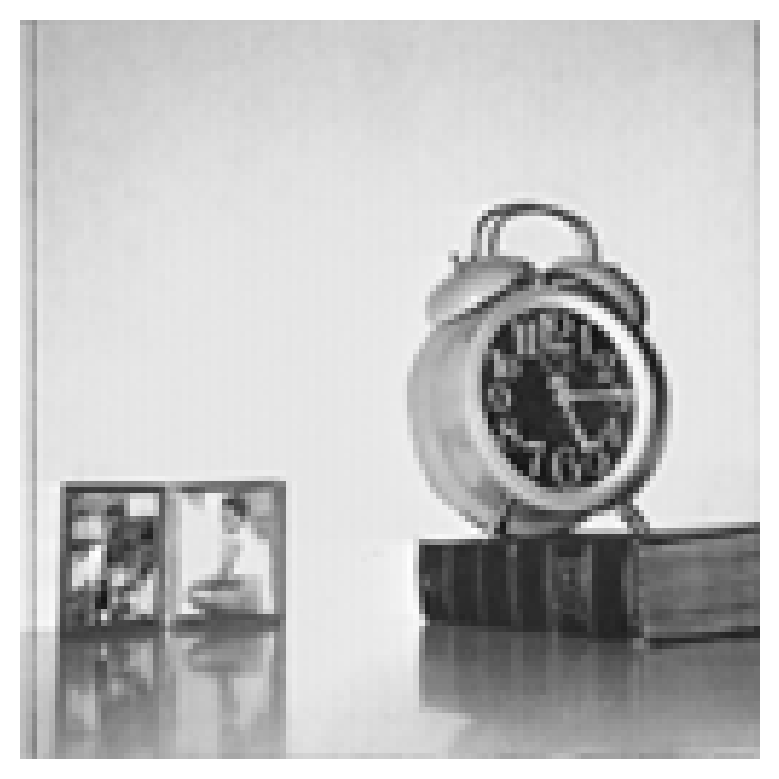

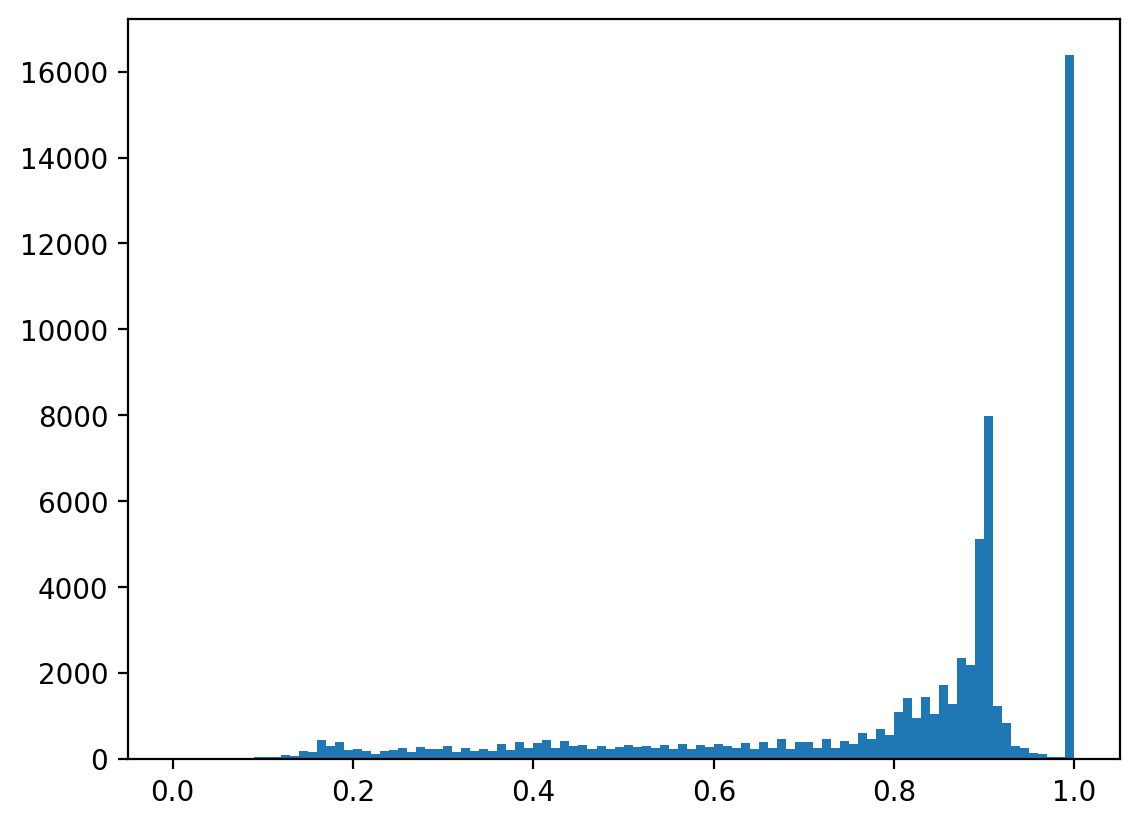

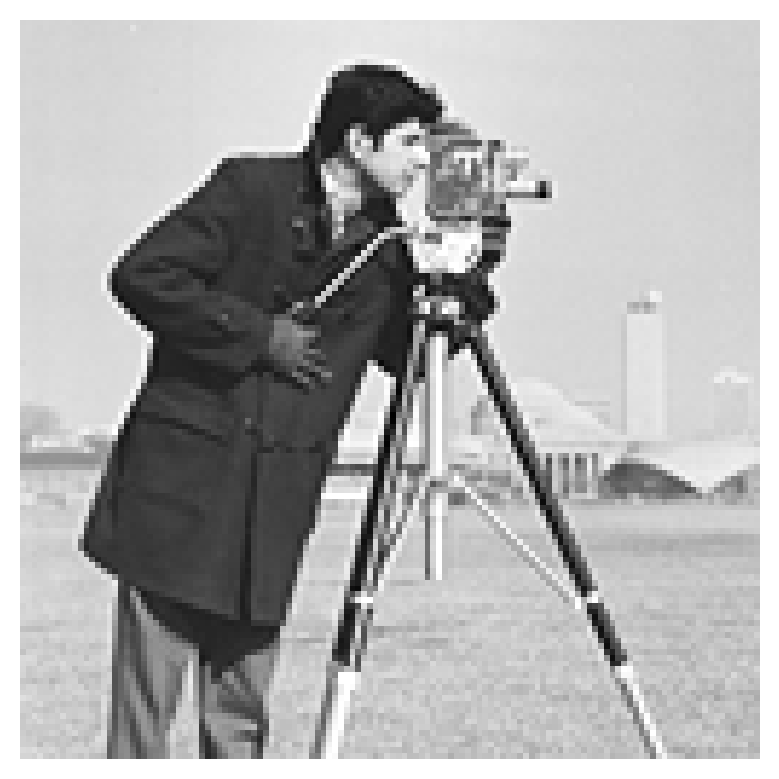

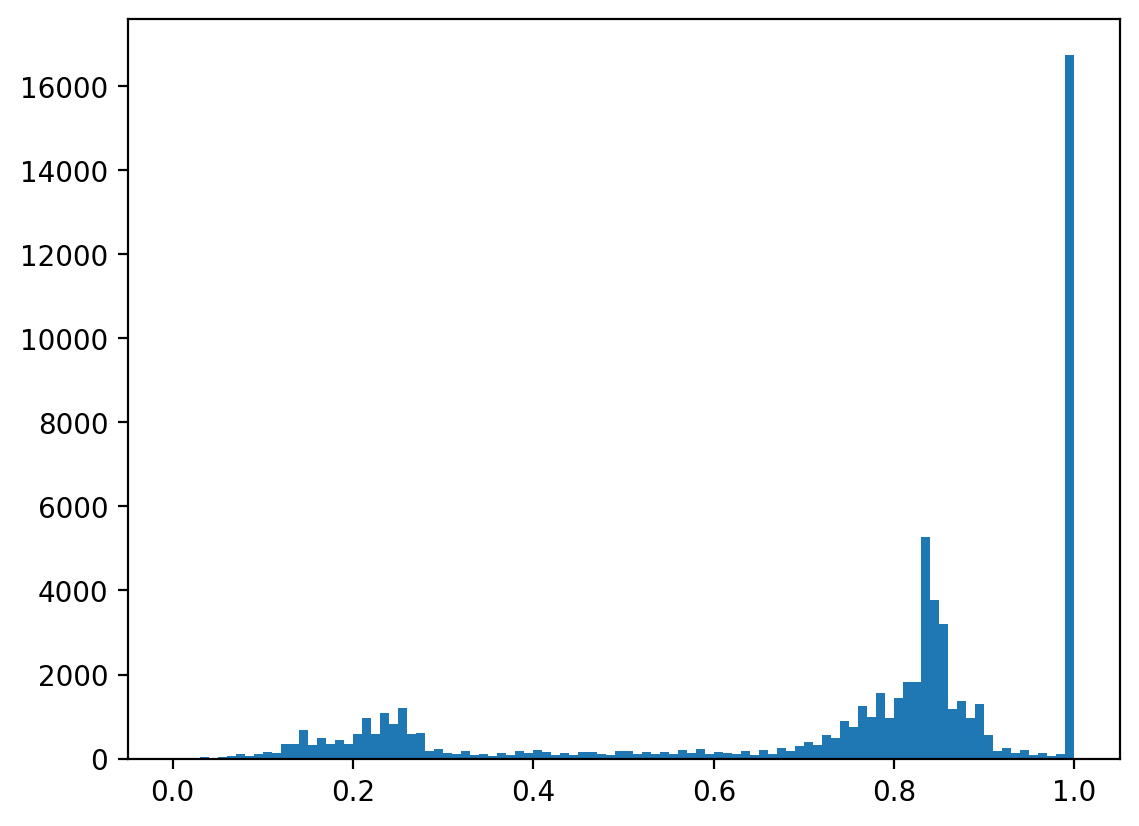

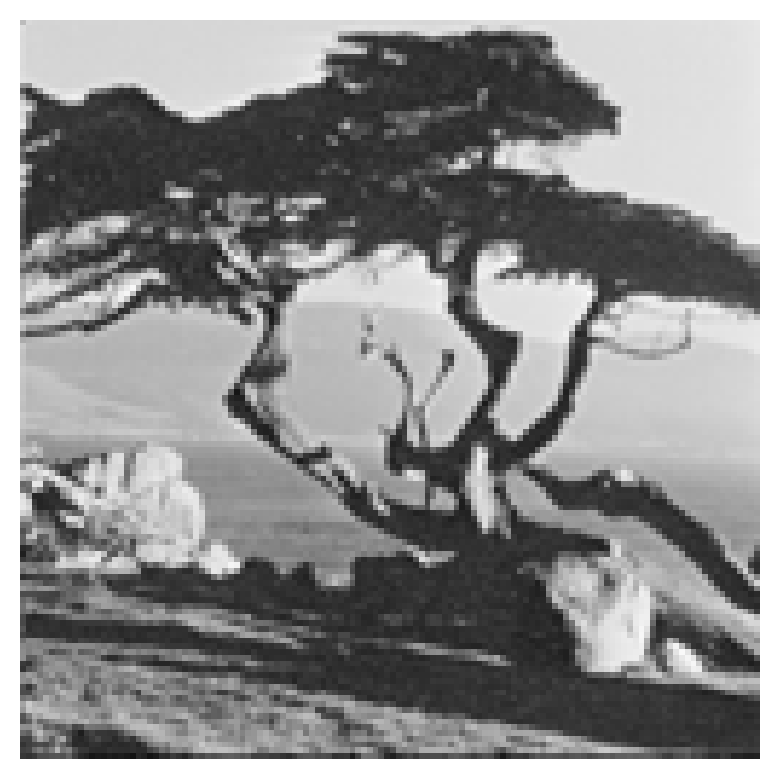

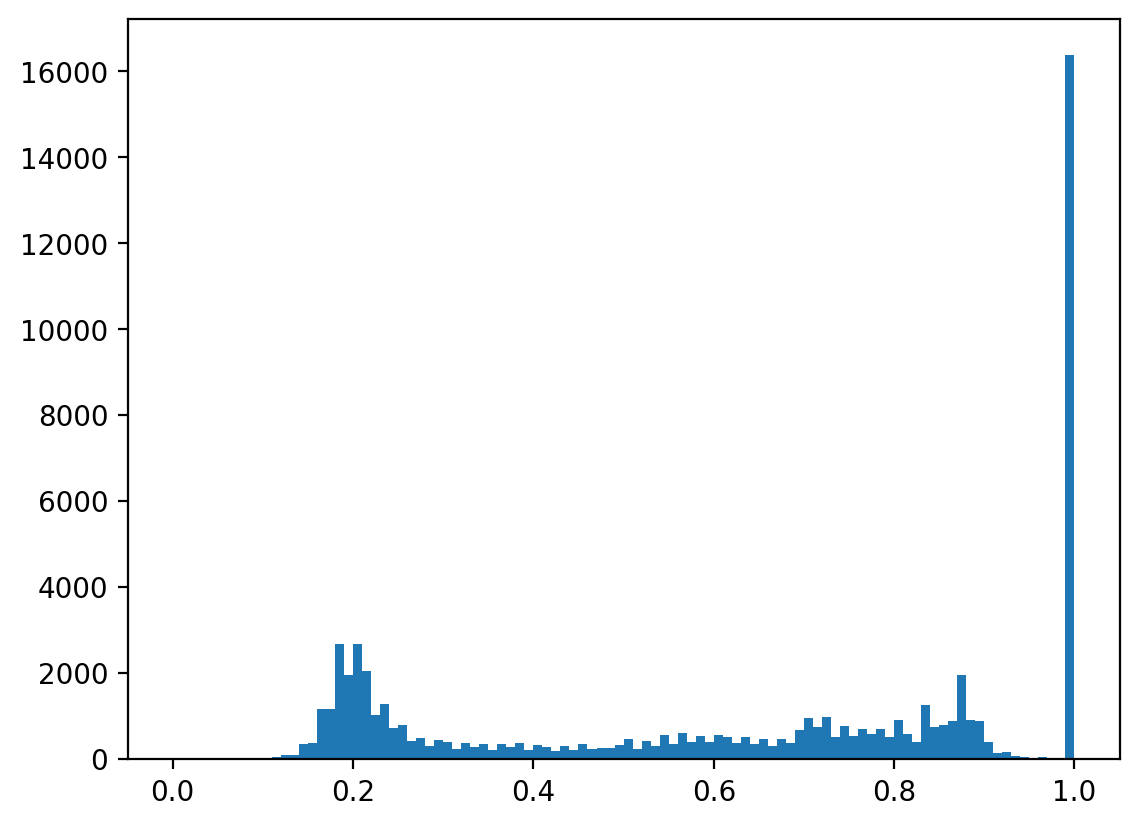

In [36]:
clock = display_images("clock.ico")
cameraman = display_images("cameraman (1).ico")
tree = display_images("tree.ico")

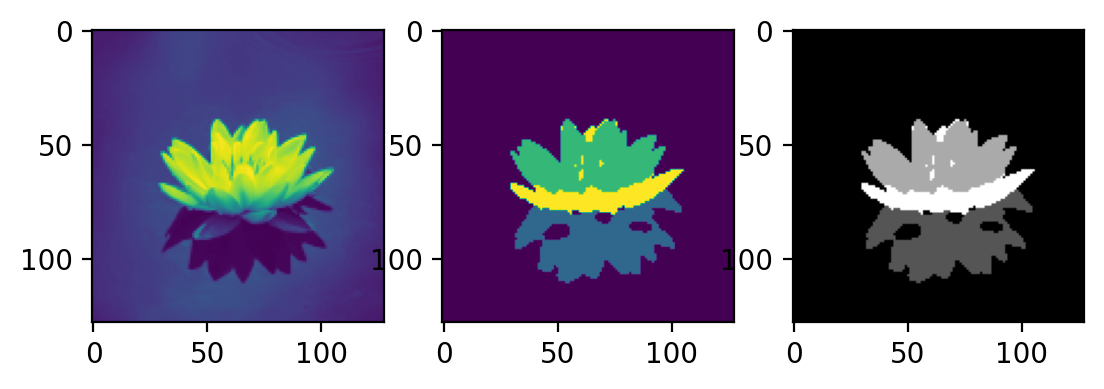

In [15]:
# for image in images:
#     plt.imshow(image)
#     final_result(get_grayscale_vals(image), 100, 4)

final_result(get_grayscale_vals(images[0]), 100, 4)

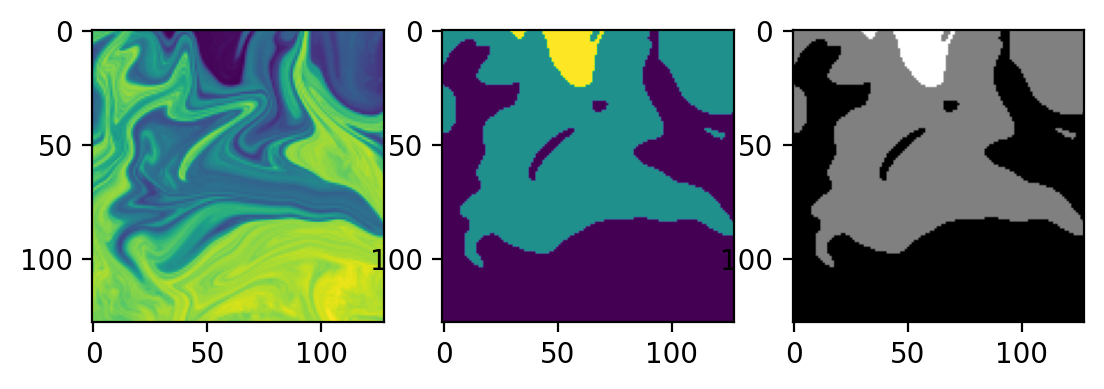

In [16]:
final_result(get_grayscale_vals(images[1]), 100, 3)

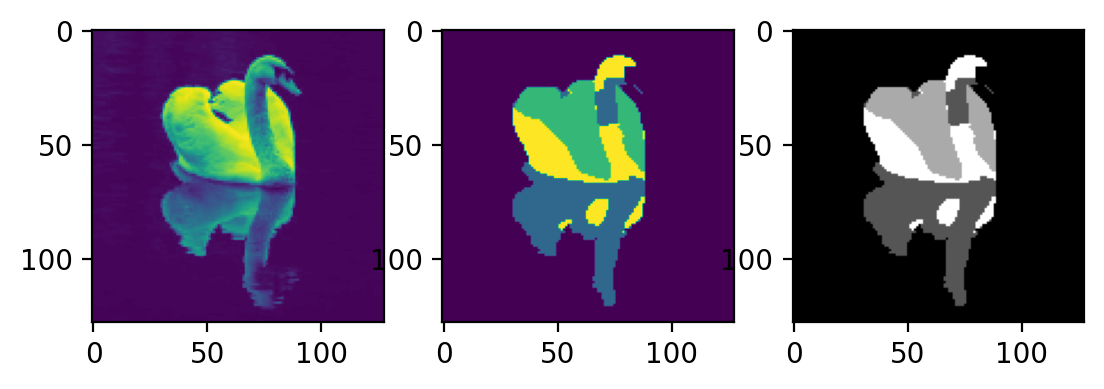

In [17]:
final_result(get_grayscale_vals(images[2]), 100, 4)

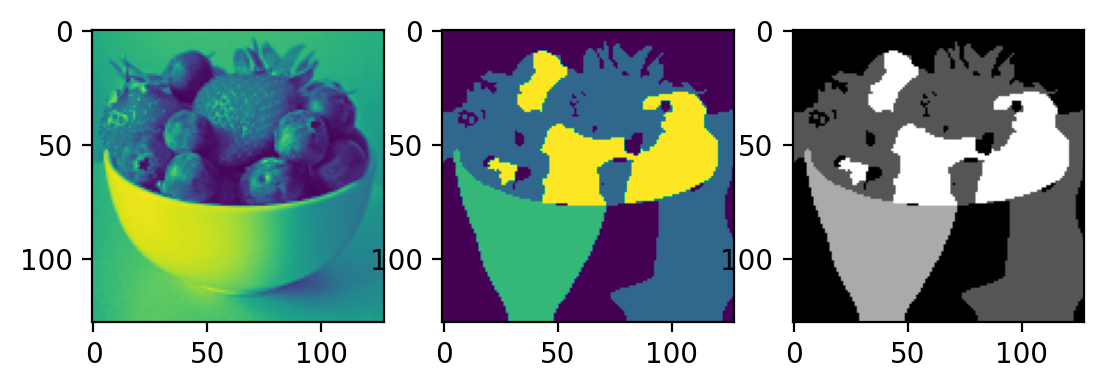

In [18]:
final_result(get_grayscale_vals(images[3]), 100, 4)

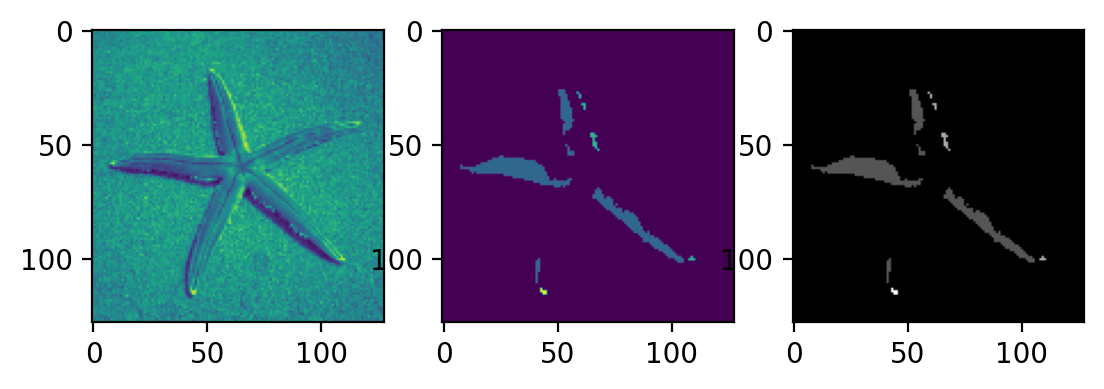

In [19]:
final_result(get_grayscale_vals(images[4]), 100, 4)

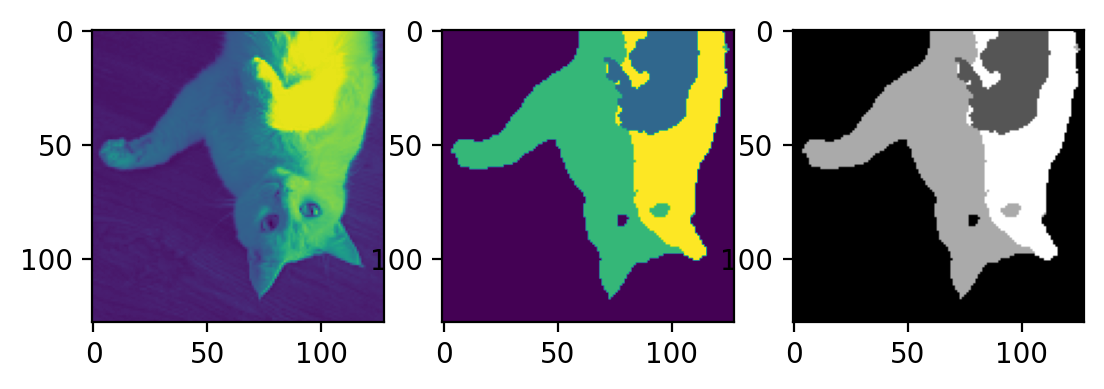

In [20]:
final_result(get_grayscale_vals(images[5]), 100, 4)

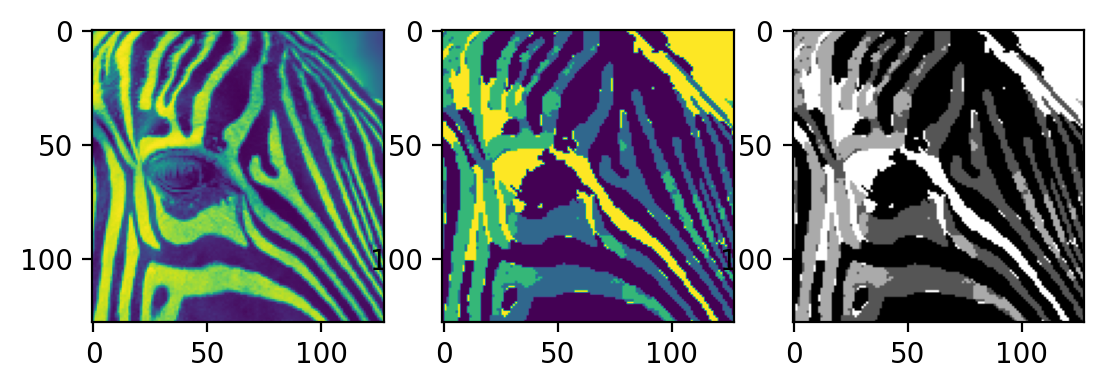

In [21]:
final_result(get_grayscale_vals(images[6]), 100, 4)

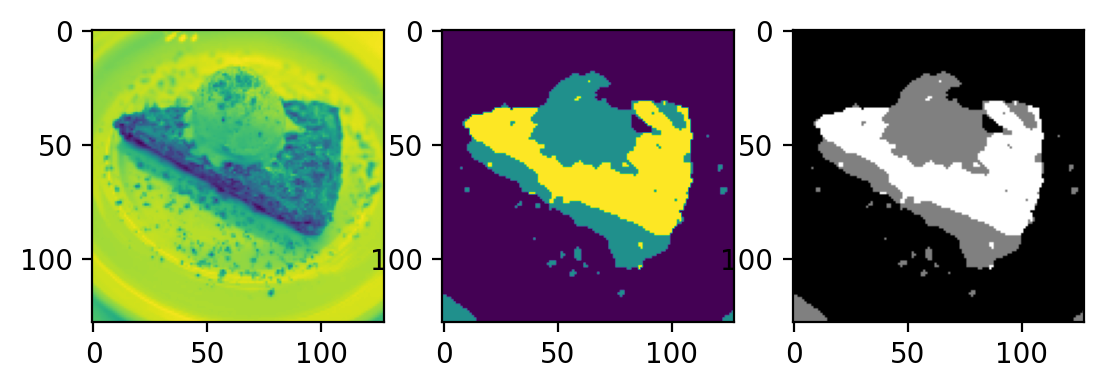

In [25]:
final_result(get_grayscale_vals(images[7]), 100, 3)

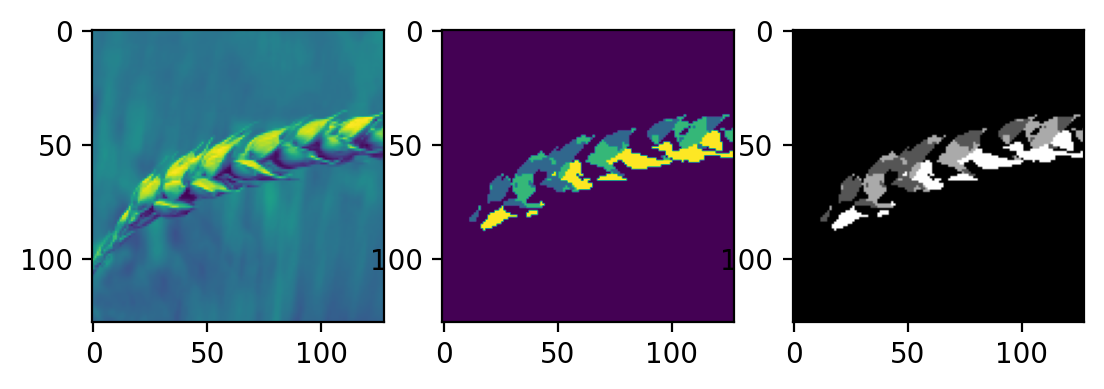

In [23]:
final_result(get_grayscale_vals(images[8]), 100, 4)

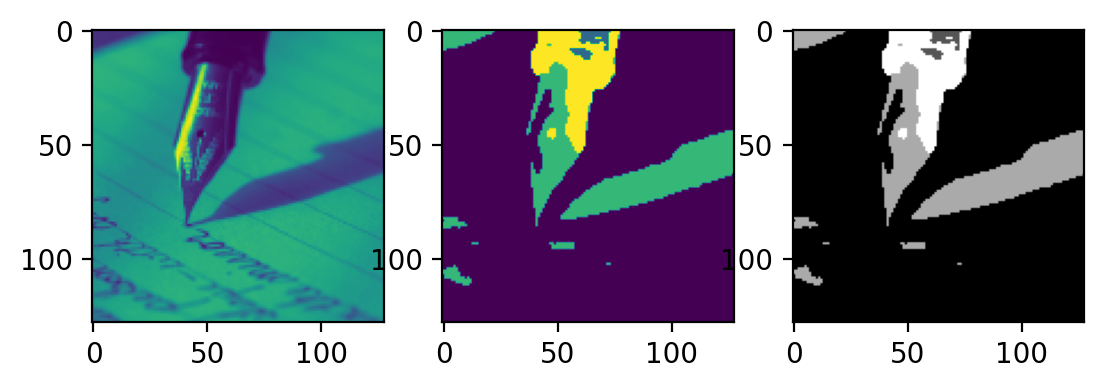

In [24]:
final_result(get_grayscale_vals(images[9]), 100, 4)

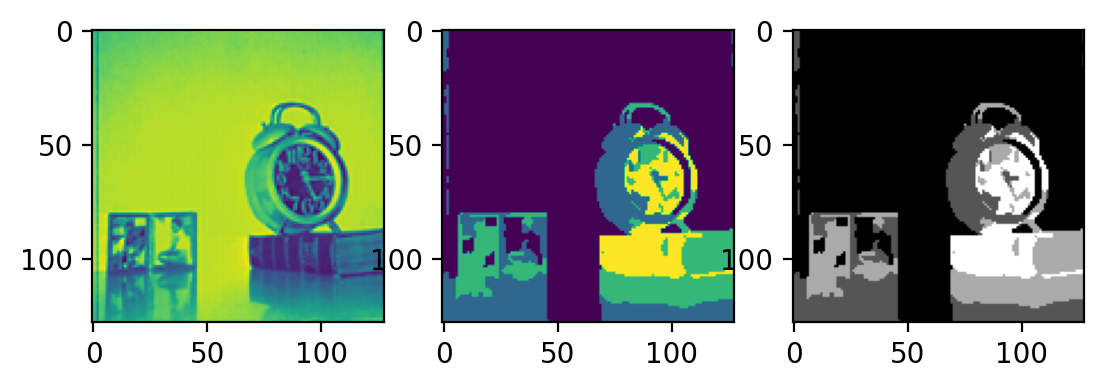

In [31]:
final_result(get_grayscale_vals(clock), 100, 4)

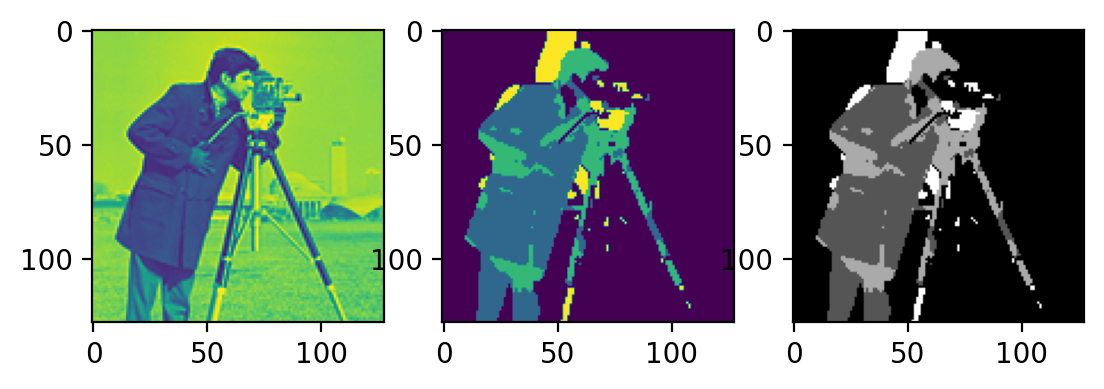

In [37]:
final_result(get_grayscale_vals(cameraman), 100, 4)

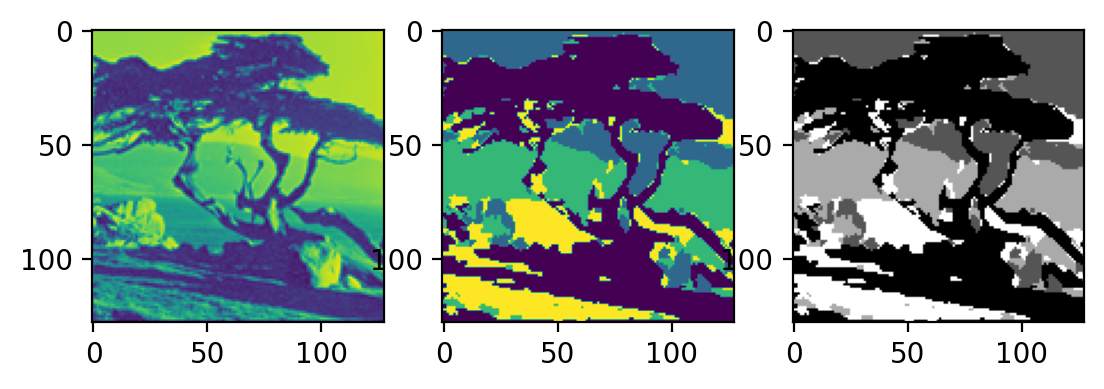

In [35]:
final_result(get_grayscale_vals(tree), 100, 4)